# 08. Pranjali1049/Salary_Prediction

## Prediction & XAI with Random Forest Regression - Salary_Data.csv

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import lime, shap
from sklearn.linear_model import LinearRegression, Lasso, Ridge, QuantileRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import xgboost
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, get_scorer_names
df = pd.read_csv('08_Salary_Data.csv')

In [2]:
# Inspect the first and last few rows of the dataset
df

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0
...,...,...,...,...,...,...
6699,49.0,Female,PhD,Director of Marketing,20.0,200000.0
6700,32.0,Male,High School,Sales Associate,3.0,50000.0
6701,30.0,Female,Bachelor's Degree,Financial Manager,4.0,55000.0
6702,46.0,Male,Master's Degree,Marketing Manager,14.0,140000.0


In [3]:
# All columns, their counts and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6704 entries, 0 to 6703
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  6702 non-null   float64
 1   Gender               6702 non-null   object 
 2   Education Level      6701 non-null   object 
 3   Job Title            6702 non-null   object 
 4   Years of Experience  6701 non-null   float64
 5   Salary               6699 non-null   float64
dtypes: float64(3), object(3)
memory usage: 314.4+ KB


In [4]:
# Get statistical info about numerical columns
df.describe()

,Age,Years of Experience,Salary
count,6702.000000,6701.000000,6699.000000
mean,33.620859,8.094687,115326.964771
std,7.614633,6.059003,52786.183911
min,21.000000,0.000000,350.000000
25%,28.000000,3.000000,70000.000000
50%,32.000000,7.000000,115000.000000
75%,38.000000,12.000000,160000.000000
max,62.000000,34.000000,250000.000000


## Preprocessing

In [5]:
# Let's check the number of null values for each column
df.isnull().sum()

Age                    2
Gender                 2
Education Level        3
Job Title              2
Years of Experience    3
Salary                 5
dtype: int64

In [6]:
# Drop these rows that contain null values
df.dropna(inplace=True)

In [7]:
print("After the drop, there are now {} rows available in the dataset.".format(len(df)))

After the drop, there are now 6698 rows available in the dataset.


In [8]:
# Check the value counts of each unique job titles
df['Job Title'].value_counts()

Software Engineer             518
Data Scientist                453
Software Engineer Manager     376
Data Analyst                  363
Senior Project Engineer       318
                             ... 
Account Manager                 1
Help Desk Analyst               1
Senior Training Specialist      1
Junior Web Designer             1
Software Project Manager        1
Name: Job Title, Length: 191, dtype: int64

In [9]:
# Let's get the number of job titles whose counts are less than 25
job_title_count = df['Job Title'].value_counts()
job_title_edited = job_title_count[job_title_count <= 25]
print("{} job titles were found.".format(job_title_edited.count()))

142 job titles were found.


In [10]:
# Let's find those job titles and change their names as 'Others'
df['Job Title'] = df['Job Title'].apply(lambda x: 'Others' if x in job_title_edited else x)
print("Now, there are {} different job titles exist, including Others.".format(df['Job Title'].nunique()))

Now, there are 50 different job titles exist, including Others.


In [11]:
# Let's check the value counts of each education Level
df['Education Level'].value_counts()

Bachelor's Degree    2265
Master's Degree      1572
PhD                  1368
Bachelor's            756
High School           448
Master's              288
phD                     1
Name: Education Level, dtype: int64

In [12]:
# Such strings need to be combined, thus replace those educations appropriately
df['Education Level'].replace(["Bachelor's Degree", "Master's Degree", "phD"],["Bachelor's", "Master's", "PhD"],inplace=True)
df['Education Level'].value_counts()

Bachelor's     3021
Master's       1860
PhD            1369
High School     448
Name: Education Level, dtype: int64

In [13]:
# Now, get the counts of gender
df['Gender'].value_counts()

Male      3671
Female    3013
Other       14
Name: Gender, dtype: int64

In [14]:
# Let's detect the outliers in salary column using IQR method
Q1 = df['Salary'].quantile(0.25)   # First Quartile
Q3 = df['Salary'].quantile(0.75)   # Third Quartile
print("Q1:", Q1, "  Q3:", Q3)
# Caltulate Interquartile
IQR = Q3 - Q1
print("IQR:", IQR)
# Deetect outliers that are 1.5x of IQR above and below Q1 and Q3 resp
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
print("LOWER:", lower, "  UPPER:", upper)

Q1: 70000.0   Q3: 160000.0
IQR: 90000.0
LOWER: -65000.0   UPPER: 295000.0


In [15]:
# Now, create dummy variables for regression
dummy_gender = pd.get_dummies(df['Gender'], prefix='gender')
dummy_education = pd.get_dummies(df['Education Level'], prefix='edu')
dummy_job_title = pd.get_dummies(df['Job Title'], prefix='job')
df_sub = pd.concat([dummy_gender, dummy_education, dummy_job_title, df['Age'], df['Years of Experience'], df['Salary']], axis=1)
df_sub

,gender_Female,gender_Male,gender_Other,edu_Bachelor's,edu_High School,edu_Master's,edu_PhD,job_Back end Developer,job_Content Marketing Manager,job_Data Analyst,...,job_Senior Project Engineer,job_Senior Research Scientist,job_Senior Software Engineer,job_Software Developer,job_Software Engineer,job_Software Engineer Manager,job_Web Developer,Age,Years of Experience,Salary
0,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,32.0,5.0,90000.0
1,1,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,28.0,3.0,65000.0
2,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,45.0,15.0,150000.0
3,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,36.0,7.0,60000.0
4,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,52.0,20.0,200000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6699,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,49.0,20.0,200000.0
6700,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,32.0,3.0,50000.0
6701,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,30.0,4.0,55000.0
6702,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,46.0,14.0,140000.0


## Prepare Train and Test Sets

In [16]:
# Use 80% of the dataset as training, and 20% as testing
X = df_sub.drop(columns='Salary', axis=1)
Y = df_sub.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print("TRAIN SIZE:", x_train.shape, y_train.shape, "  TEST SIZE:", x_test.shape, y_test.shape)

TRAIN SIZE: (5358, 59) (5358,)   TEST SIZE: (1340, 59) (1340,)


## Predict with Random Forest Regression

In [17]:
rforest = RandomForestRegressor(oob_score=True)
rforest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': True,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [19]:
# Fit the training data into the random forest, then make predictions on the test data
rforest.fit(x_train, y_train)
y_pred = rforest.predict(x_test)

In [20]:
# Show the attributes for each random forest
print("BASE ESTIMATOR:", rforest.base_estimator_)   # Estimator used to grow the ensemble
# print("ESTIMATORS:", rforest.estimators_)   # The collection of fitted sub-estimators
print("FEATURE IMPORTANCES:", rforest.feature_importances_)   # The impurity-based feature importances
# Score of the training dataset obtained using an out-of-bag estimate. Exists only when oob_score = True
print("OOB SCORE:", rforest.oob_score_)
# Prediction computed with out-of-bag estimate on the training set. Exists only when oob_score = True
print("OOB PREDICTION:", rforest.oob_prediction_, "", len(rforest.oob_prediction_))
print("FEATURES:", rforest.n_features_in_)   # Number of features seen during fit
print("OUTPUTS:", rforest.n_outputs_, "\n")   # The number of outputs when fit is performed

BASE ESTIMATOR: DecisionTreeRegressor()
FEATURE IMPORTANCES: [2.77024736e-03 3.38978582e-03 1.06351025e-04 5.02953661e-03
 9.58791958e-03 3.42148206e-03 7.41377038e-03 4.54733860e-03
 8.81368944e-05 3.30012837e-02 3.60744860e-02 1.14949027e-04
 1.61645358e-03 1.88324206e-03 2.66135495e-04 1.98159929e-04
 3.22029061e-03 2.08331029e-04 2.85713702e-03 6.03861404e-03
 4.56772828e-05 2.89584811e-04 2.21705526e-04 3.39040867e-04
 3.43798699e-05 1.26783511e-04 4.05981560e-05 8.19053905e-04
 1.04654713e-04 4.95115321e-05 1.59021176e-04 1.62753649e-04
 2.80968314e-03 1.82493452e-03 6.11616196e-04 5.97269692e-03
 8.17239562e-05 1.84029250e-02 0.00000000e+00 2.92319927e-04
 2.32329366e-04 7.68871307e-05 1.42429968e-03 8.85996376e-05
 3.37216310e-04 1.52301647e-04 3.08123418e-04 2.37647273e-04
 6.78957308e-04 3.03270275e-04 3.57357956e-03 1.03244826e-03
 3.38183857e-03 3.55336657e-04 3.12134303e-02 4.39835568e-03
 2.52626501e-04 4.46995508e-02 7.53030886e-01]
OOB SCORE: 0.9786174050193127
OOB PRED

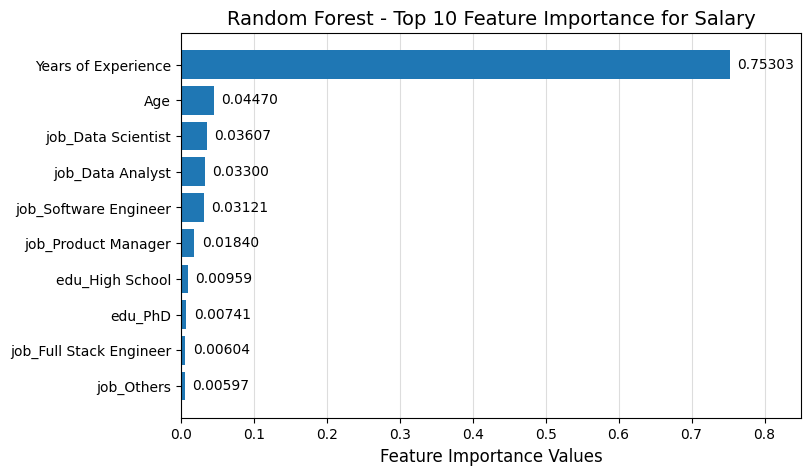

In [21]:
rforest_feat_impr = pd.Series(rforest.feature_importances_, index=df_sub.columns[:x_train.shape[1]]).sort_values(ascending=False)[:10]
plt.figure(figsize=(8,5))
plt.barh(rforest_feat_impr.index[::-1], rforest_feat_impr[::-1], zorder=2)
plt.xlim(0.0, 0.85)
for i in range(len(rforest_feat_impr)):
    plt.text(rforest_feat_impr[i]+0.01, 9-i-0.1, "{:.5f}".format(rforest_feat_impr[i]))
plt.title("Random Forest - Top 10 Feature Importance for Salary", fontsize=14)
plt.xlabel('Feature Importance Values', fontsize=12)
plt.grid(color='#dddddd', axis='x', zorder=1)
plt.show()

In [22]:
# Compare the predicted values against the actual ones for the first 20 rows of the test set
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

            150000.0 | 150000.0
           82596.065 |  75969.0
            100000.0 | 100000.0
   61544.56371493704 |  60000.0
             80000.0 |  80000.0
  193790.24718036037 | 190000.0
             72000.0 |  72000.0
   55035.33333333334 |  55000.0
  197429.33578880655 | 195000.0
  131888.52331874383 | 130000.0
            100000.0 | 100000.0
  25881.815945492413 |  25000.0
   64423.68421052631 |  70000.0
            121525.0 | 120000.0
            140000.0 | 140000.0
            194730.0 | 195000.0
   83874.68134672352 |  75000.0
            140000.0 | 140000.0
            130000.0 | 130000.0
             80000.0 |  80000.0


In [23]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
print("MSE:", mse)        
print("RMSE:", rmse)      
print("MAE:", mae)        
print("R2 SCORE:", r2)  
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(rforest, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())

MSE: 70163624.86896953
RMSE: 8376.37301395834
MAE: 3223.7614924731733
R2 SCORE: 0.9753937830587976

# CROSS VALIDATION #
FITTING TIME: [1.10578823 1.21361113 1.17063403 1.206038   1.13581681] -> 1.166377639770508
SCORING TIME: [0.02195573 0.01900339 0.01921415 0.01904273 0.01789594] -> 0.019422388076782225
TRAIN SCORE: [0.99744767 0.98993197 0.98950692 0.98862801 0.99016193] -> 0.9911353005280246
TEST SCORE: [-0.19186277  0.87477259  0.96350876  0.91383932  0.73698075] -> 0.6594477302181168


## Explain the Model with SHAP

In [24]:
shap.initjs()
shap_explainer = shap.Explainer(rforest, x_train)
shap_values = shap_explainer(x_test)
print(shap_values.shape)
print(shap_values)
print("\n EXPECTED VALUE:", shap_explainer.expected_value)

 99%|===================| 1327/1340 [00:26<00:00]        

(1340, 59)
.values =
array([[ 2.13171939e+02,  2.78367360e+02,  0.00000000e+00, ...,
         1.26840098e+01, -1.13307826e+04,  4.13897568e+04],
       [-5.55317876e+02, -6.57256830e+02,  0.00000000e+00, ...,
         3.74978270e+00,  2.43759617e+03, -1.99576298e+04],
       [-1.04442032e+03, -1.16374859e+03,  0.00000000e+00, ...,
         5.30373244e+00,  4.27659339e+03, -3.62732202e+04],
       ...,
       [-3.10277515e+02, -3.74822553e+02,  0.00000000e+00, ...,
         7.58494263e+01,  7.17882439e+03,  1.90829858e+03],
       [-5.31048391e+02, -1.05424951e+03,  0.00000000e+00, ...,
         2.01307655e+00, -1.94059836e+04,  4.76475205e+04],
       [ 2.16549837e+00,  1.32962920e+02,  0.00000000e+00, ...,
         4.03413240e+01,  4.27044312e+03, -3.42658498e+04]])

.base_values =
array([102605.62900546, 102605.62900546, 102605.62900546, ...,
       102605.62900546, 102605.62900546, 102605.62900546])

.data =
array([[ 0.,  1.,  0., ...,  0., 36.,  9.],
       [ 1.,  0.,  0., ...,  0.

### SUMMARY OF EXPLAINABILITY WITH SHAP ###


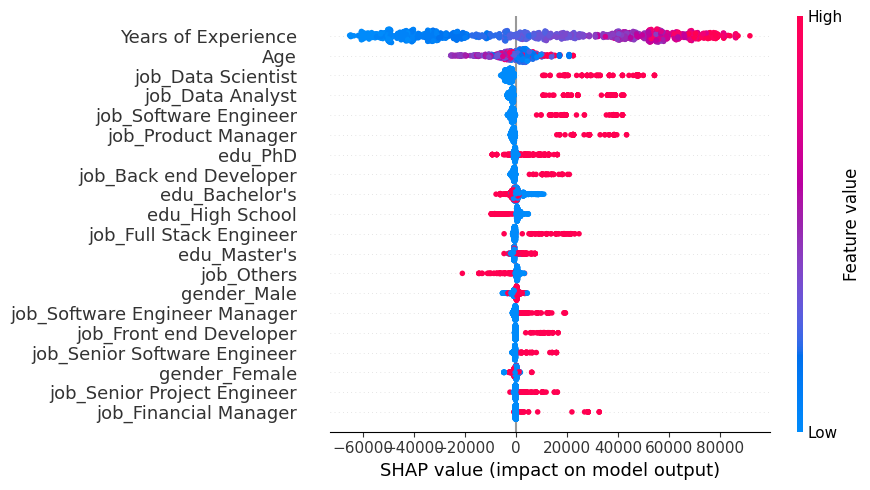

In [25]:
print("### SUMMARY OF EXPLAINABILITY WITH SHAP ###")
# shap.plots.beeswarm(shap_values)
shap.summary_plot(shap_values, x_test, plot_type='dot', plot_size=[9,5])

In [26]:
print("### VISUALIZATION OF FIRST 500 PREDICTIONS ###")
shap.plots.force(shap_values[:500])

### VISUALIZATION OF FIRST 500 PREDICTIONS ###


### MEAN ABSOLUTE VALUES OF SHAP VALUES ###


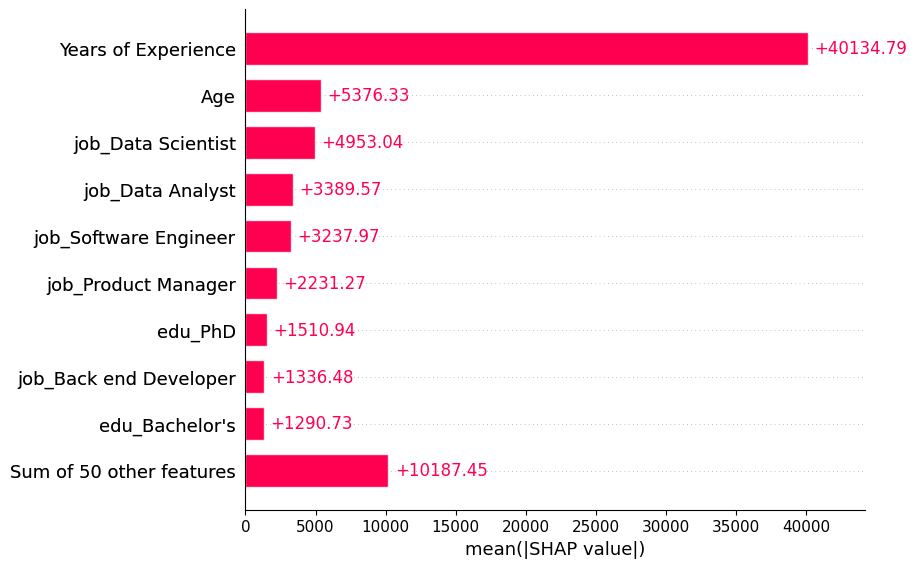

In [27]:
print("### MEAN ABSOLUTE VALUES OF SHAP VALUES ###")
shap.plots.bar(shap_values)

### DEPENDENCY BETWEEN THE FIRST COLUMN & THE BEST INTERACTION ###


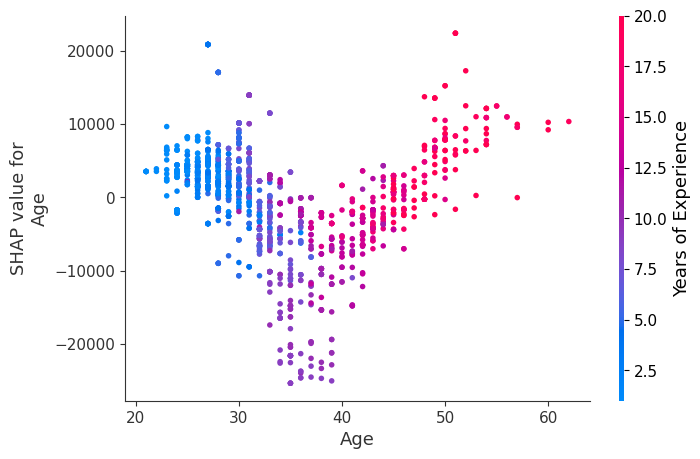

In [28]:
print("### DEPENDENCY BETWEEN THE FIRST COLUMN & THE BEST INTERACTION ###")
shap.dependence_plot("Age", shap_values.values, x_test)

### EXPLAINING TEST ROW 234 WITH SHAP ###


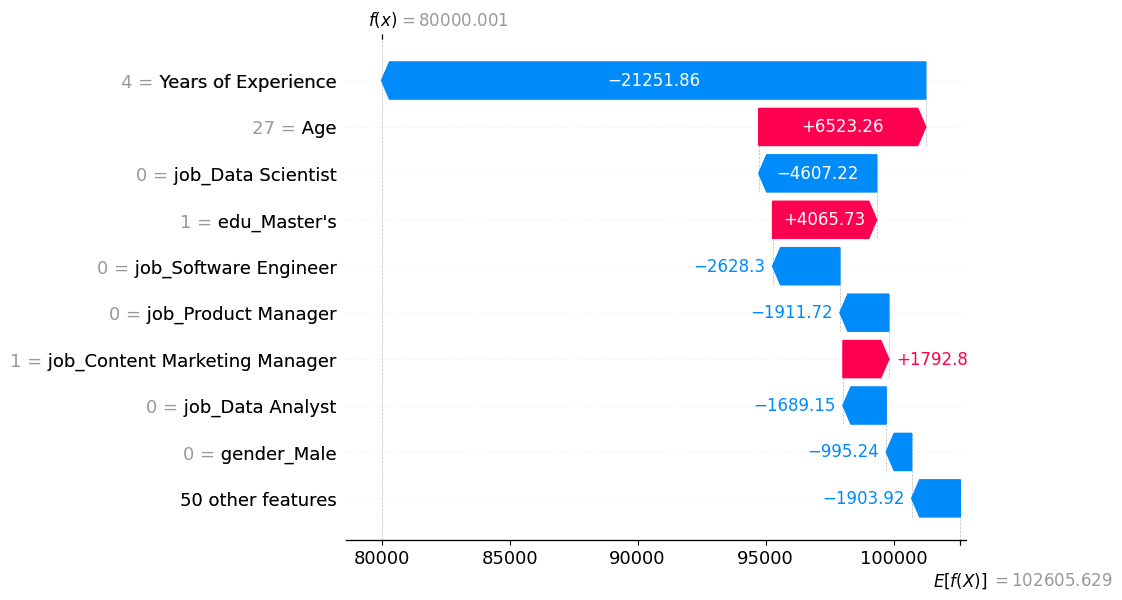

In [32]:
# i = 0
import random
i = random.randint(0, x_test.shape[0]-1)
print("### EXPLAINING TEST ROW {} WITH SHAP ###".format(i))
shap.plots.waterfall(shap_values[i])

In [33]:
print("### EXPLAINING TEST ROW {} WITH SHAP ###".format(i))
shap.plots.force(shap_values[i])

### EXPLAINING TEST ROW 234 WITH SHAP ###


## Explain the Model with LIME

In [34]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(x_train.values, feature_names=df_sub.columns, 
                                                        class_names=['Salary'], verbose=True, mode='regression')

In [38]:
i = random.randint(0, x_test.shape[0]-1)
print("### EXPLAINING TEST ROW {} WITH LIME ###".format(i))
exp = lime_explainer.explain_instance(x_test.iloc[i], rforest.predict, num_features=10)
exp.show_in_notebook(show_table=True)
exp.as_list()

### EXPLAINING TEST ROW 60 WITH LIME ###
Intercept 202474.59906764553
Prediction_local [152634.77505641]
Right: 170000.0


[('Years of Experience > 12.00', 64942.457485643456),
 ('job_Data Scientist <= 0.00', -37367.67211347321),
 ('job_Data Analyst <= 0.00', -25511.7072518007),
 ('job_Product Manager <= 0.00', -24775.5024608317),
 ('job_Software Engineer <= 0.00', -15586.049094821536),
 ('gender_Other <= 0.00', -14879.213096985812),
 ('job_Senior Research Scientist <= 0.00', 14230.108918361493),
 ('job_Sales Manager <= 0.00', 13657.582470723775),
 ('job_Financial Manager <= 0.00', -12466.716626988009),
 ('job_Full Stack Engineer <= 0.00', -12083.11224106635)]